In [5]:
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import KFold
from create_matrix import *
import os
import sys
from tensor_custom_core import *
from create_matrix import *
from tensor_custom_core import *
from degree_days import dds
from sklearn.model_selection import train_test_split, KFold
from common import compute_rmse_fraction
from common import compute_rmse

appliance_index = {appliance: APPLIANCES_ORDER.index(appliance) for appliance in APPLIANCES_ORDER}
APPLIANCES = ['fridge', 'hvac', 'wm', 'mw', 'oven', 'dw']
year = 2014
n_splits = 10
case=2
a=2
cost='abs'

In [6]:
def un_normalize(x, maximum, minimum):
    return (maximum - minimum) * x + minimum

def get_tensor(df, dfc):
    start, stop = 1, 13
    energy_cols = np.array(
        [['%s_%d' % (appliance, month) for month in range(start, stop)] for appliance in APPLIANCES_ORDER]).flatten()

    static_cols = ['area', 'total_occupants', 'num_rooms']
    static_df = df[static_cols]
    static_df = static_df.div(static_df.max())
    weather_values = np.array(dds[2014][region][start - 1:stop - 1]).reshape(-1, 1)

    dfc = df.copy()

    df = dfc[energy_cols]
    col_max = df.max().max()
    col_min = df.min().min()
    # df = (1.0 * (df - col_min)) / (col_max - col_min)
    tensor = df.values.reshape((len(df), 7, stop - start))
    M, N, O = tensor.shape
    return tensor

In [7]:
region = "SanDiego"
sd_df, sd_dfc = create_matrix_single_region("SanDiego", year)
sd_tensor = get_tensor(sd_df, sd_dfc)
region = "Austin"
au_df, au_dfc = create_matrix_single_region("Austin", year)
au_tensor = get_tensor(au_df, au_dfc)

In [8]:
def load_obj(name ):
    with open(os.path.expanduser('~/git/' + name + '.pkl'), 'rb') as f:
        return pickle.load(f)

In [9]:
import pickle
pred = {}
for method in ['normal', 'transfer']:
    pred[method] = {}
    for cost in ['abs', 'rel']:
        pred[method][cost] = {}
        for iterations in [2000, 10000, 15000]:
            pred[method][cost][iterations] = load_obj("pred_" + method + "_" + cost + "_" + str(iterations)) 

In [10]:
out = {}
for method in ['normal', 'transfer']:
    out[method] = {}
    for cost in ['abs', 'rel']:
        out[method][cost] = {}
        for iterations in [2000, 10000, 15000]:
            out[method][cost][iterations] = {}
            for random_seed in range(10):
                out[method][cost][iterations][random_seed] = {}
                for appliance in APPLIANCES_ORDER[1:]:
                    out[method][cost][iterations][random_seed][appliance] = {}
                    for f in range(10,110,10):
                        s = pd.concat(pred[method][cost][iterations][random_seed][appliance][f]).ix[sd_df.index]
                        if appliance=="hvac":
                            out[method][cost][iterations][random_seed][appliance][f] = compute_rmse_fraction(appliance,s[range(4, 10)],'SanDiego')[2]
                        else:   
                            out[method][cost][iterations][random_seed][appliance][f] = compute_rmse_fraction(appliance, s,'SanDiego')[2]


/Users/xox/Library/Python/2.7/lib/python/site-packages/ipykernel_launcher.py:13: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  del sys.path[0]


In [14]:
mean_out = {}
for method in ['normal', 'transfer']:
    mean_out[method] = {}
    for cost in ['abs', 'rel']:
        mean_out[method][cost] = {}
        for iterations in [2000, 10000, 15000]:
            mean_out[method][cost][iterations] = pd.Panel(out[method][cost][iterations]).mean(axis=0)

In [15]:
# test = {}
for method in ['normal', 'transfer']:
    for cost in ['abs', 'rel']:
        for iterations in [2000, 10000, 15000]:
            mean_out[method][cost][iterations] = mean_out[method][cost][iterations].rename(
                                                columns = {'dw': "dw_" + method + "_" + cost + "_" + str(iterations),
                                                          'wm': "wm_" + method + "_" + cost + "_" + str(iterations),
                                                          'mw': "mw_" + method + "_" + cost + "_" + str(iterations),
                                                          'oven': "oven_" + method + "_" + cost + "_" + str(iterations),
                                                          'fridge': "fridge_" + method + "_" + cost + "_" + str(iterations),
                                                          'hvac': "hvac_" + method + "_" + cost + "_" + str(iterations)})

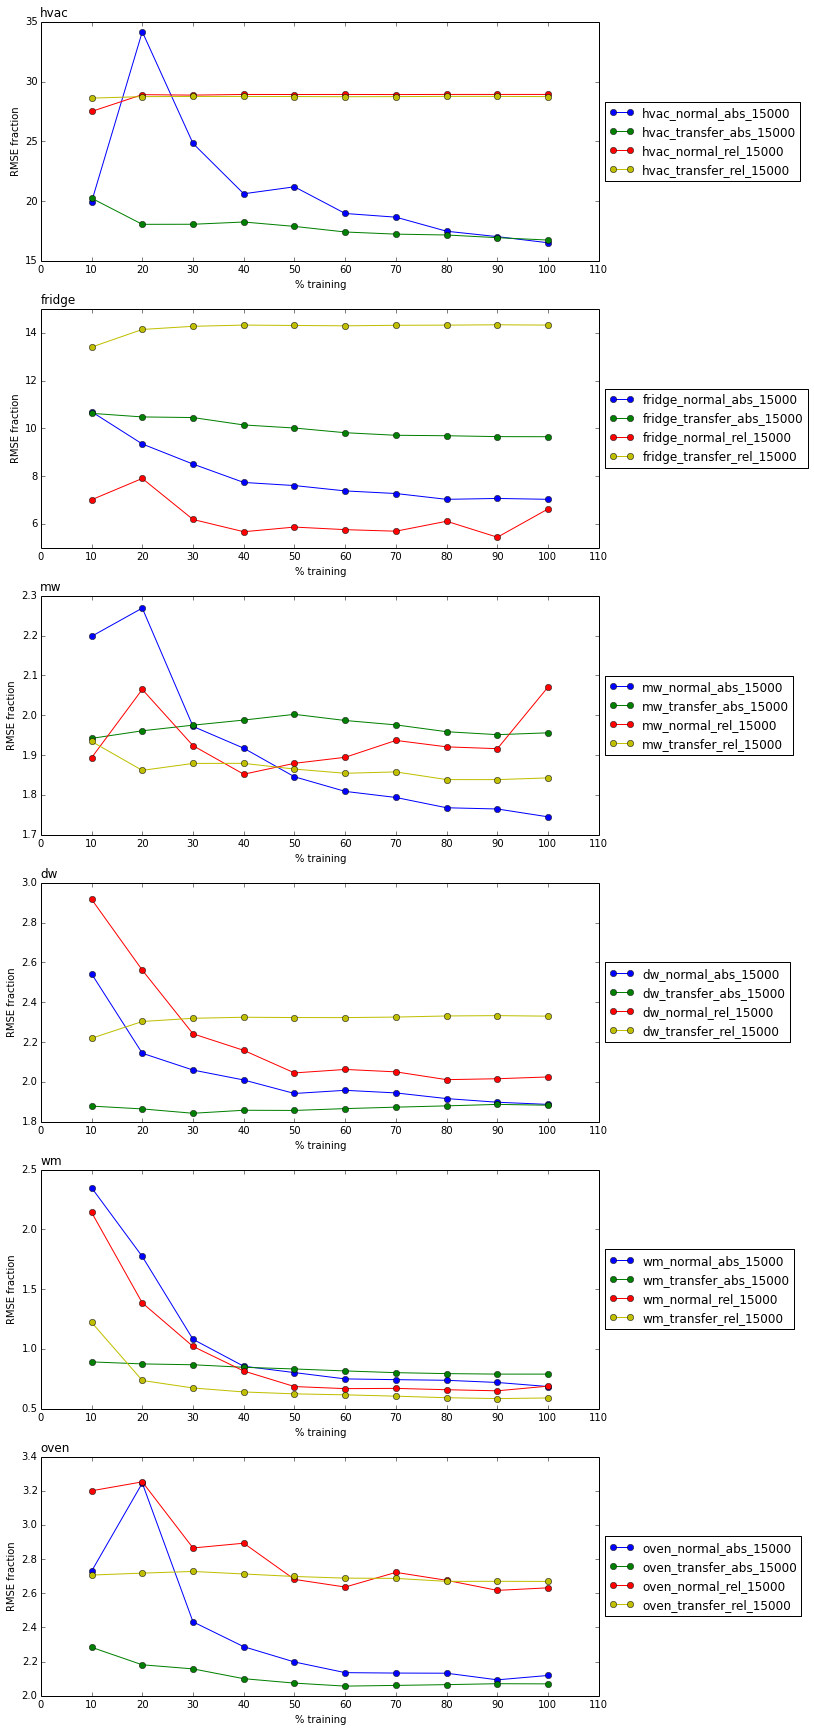

In [16]:
fig, axes = plt.subplots(nrows=6, ncols=1, figsize=(50, 100))
ax = axes.flatten()
count = 0

dfs = {}

for appliance in APPLIANCES_ORDER[1:]: 
    
    df1 = mean_out['normal']['abs'][2000][appliance + '_normal_abs_2000']
    df2 = mean_out['transfer']['abs'][2000][appliance + '_transfer_abs_2000']
    df3 = mean_out['normal']['rel'][2000][appliance + '_normal_rel_2000']
    df4 = mean_out['transfer']['rel'][2000][appliance + '_transfer_rel_2000']

    df5 = mean_out['normal']['abs'][10000][appliance + '_normal_abs_10000']
    df6 = mean_out['transfer']['abs'][10000][appliance + '_transfer_abs_10000']
    df7 = mean_out['normal']['rel'][10000][appliance + '_normal_rel_10000']
    df8 = mean_out['transfer']['rel'][10000][appliance + '_transfer_rel_10000'] 
    
    df9 = mean_out['normal']['abs'][15000][appliance + '_normal_abs_15000']
    df10 = mean_out['transfer']['abs'][15000][appliance + '_transfer_abs_15000']
    df11 = mean_out['normal']['rel'][15000][appliance + '_normal_rel_15000']
    df12 = mean_out['transfer']['rel'][15000][appliance + '_transfer_rel_15000']
#     df4 = all_out[appliance+ '_transfer_reg']

#     df = pd.concat([df3, df4], axis=1)
    df = pd.concat([df9, df10, df11, df12], axis=1)
    pd.DataFrame(df).plot(ax=ax[count],figsize=(10, 30), marker='o', xlim=(0, 110), color=['b', 'g','r', 'y', 'k', 'c'])
    ax[count].legend(loc='center left', bbox_to_anchor=(1.0, 0.5))

    ax[count].set_xlabel("% training");
    ax[count].locator_params(tight=False, nbins=20, axis='x')
    ax[count].set_ylabel('RMSE fraction')
    ax[count].set_title(appliance, loc="left")
    count += 1
# plt.savefig("./analysis/0711/prediction_normal_transfer_abs_rel_10k.pdf", bbox_inches="tight", dpi=300, format="pdf")

### -------------------------------------------------------------------------------------------------------------------------------
### Regularization exploration

## Normal learning with regularization term

In [64]:
import autograd.numpy as np
from numpy import linalg as LA
from autograd import multigrad

def cost_abs_reg(H, A, T, E_np_masked, case):
    la = 10
    HAT = multiply_case(H, A, T, case)
    mask = ~np.isnan(E_np_masked)
    error = (HAT - E_np_masked)[mask].flatten() + la * LA.norm(~np.isnan(H)) + la * LA.norm(~np.isnan(A)) + la * LA.norm(~np.isnan(T))
    return np.sqrt((error ** 2).mean())

def learn_HAT_reg(case, E_np_masked, a, b, num_iter=2000, lr=0.1, dis=False, cost_function='abs', H_known=None,
              A_known=None, T_known=None, random_seed=0, random_mul_constant=1,
              random_add_constant=0):
    np.random.seed(random_seed)
    if cost_function == 'abs':
        cost = cost_abs_reg
    else:
        cost = cost_rel
    mg = multigrad(cost, argnums=[0, 1, 2])

    params = {}
    params['M'], params['N'], params['O'] = E_np_masked.shape
    params['a'] = a
    params['b'] = b
    H_dim_chars = list(cases[case]['HA'].split(",")[0].strip())
    H_dim = tuple(params[x] for x in H_dim_chars)
    A_dim_chars = list(cases[case]['HA'].split(",")[1].split("-")[0].strip())
    A_dim = tuple(params[x] for x in A_dim_chars)
    T_dim_chars = list(cases[case]['HAT'].split(",")[1].split("-")[0].strip())
    T_dim = tuple(params[x] for x in T_dim_chars)
    H = np.random.rand(*H_dim)*random_mul_constant+random_add_constant

    A = np.random.rand(*A_dim)*random_mul_constant+random_add_constant
    T = np.random.rand(*T_dim)*random_mul_constant+random_add_constant

    # GD procedure
    for i in range(num_iter):
        del_h, del_a, del_t = mg(H, A, T, E_np_masked, case)
        H -= lr * del_h
        A -= lr * del_a
        T -= lr * del_t
        # Projection to known values
        if H_known is not None:
            H = set_known(H, H_known)
        if A_known is not None:
            A = set_known(A, A_known)
        if T_known is not None:
            T = set_known(T, T_known)
        # Projection to non-negative space
        H[H < 0] = 0
        A[A < 0] = 0
        T[T < 0] = 0
        if i % 500 == 0:
            if dis:
                print(cost(H, A, T, E_np_masked, case))
    return H, A, T